# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [1]:
import pyaudio
import houndify
import wave
import numpy as np
import wolframalpha
import requests
from bs4 import BeautifulSoup
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime import text as mimetext
from email.utils import COMMASPACE, formatdate

class MyListener(houndify.HoundListener): # extending the class
    #def onPartialTranscript(self, transcript):
        #print("Partial transcript: " + transcript)
    #def onFinalResponse(self, response):
        #print("Final response: " + str(response))
    def onError(self, err):
        print("Error: " + str(err))

def record_audio(length): # record an audio snippet
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000 # compatible with Houndify
    RECORD_SECONDS = length
    WAVE_OUTPUT_FILENAME='My_Audio.wav'
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    print("Recording...")
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        if i%np.round(RATE/chunk) == 0: print(i/np.round(RATE/chunk)+1) # print seconds
        data = stream.read(chunk)
        all.append(data)
    print("* done recording\n")
    stream.close()
    p.terminate()
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    print("Writing",WAVE_OUTPUT_FILENAME)
    wf.close()
    return WAVE_OUTPUT_FILENAME

def parse_audio(audio): # parse an audio file to text
    BUFFER_SIZE = 512
    clientId = "P6RXoXz6B477vU4eg5AB5Q=="
    clientKey = "WlkneGAZZKw713g5V3wuf5olyXXdSRePX86Hp16fY-mka71pW7jZF_ILb80KbVi8cFEKv1tzbfq_kTvkDKzcsg=="
    userId = "test_user"
    client = houndify.StreamingHoundClient(clientId, clientKey, userId, sampleRate=8000)
    client.setSampleRate(audio.getframerate())
    client.start(MyListener())
    while True: # load in audio
        samples = audio.readframes(BUFFER_SIZE)
        if len(samples) == 0: break
        if client.fill(samples): break
    result = client.finish() # returns either final response or error
    text = result['Disambiguation']['ChoiceData'][0]['Transcription'] # parse transcript
    return text

def mail(sender, pwd, to, subject, text): # simple email function
    msg = MIMEMultipart()
    msg["From"] = sender
    msg["To"] = COMMASPACE.join(to)
    msg["Date"] = formatdate(localtime=True)
    msg["Subject"] = subject
    msg.attach(mimetext.MIMEText(text))
    mailServer = smtplib.SMTP("smtp.gmail.com", 587)
    mailServer.starttls()
    mailServer.login(sender, pwd)
    mailServer.sendmail(sender, to, msg.as_string())
    mailServer.close()

def tell_joke(): # find a joke on the web
    req = requests.get(f"https://www.rd.com/jokes/") # XXX a finite sample of jokes to choose from
    soup = BeautifulSoup(req.text,"html.parser")
    jokes = soup.findAll('p')
    qs = [] # questions
    ans = [] # answers
    for joke in jokes:
        line = joke.get_text()
        if 'Q.' in line or 'Q:' in line: qs.append(line)
        if 'A.' in line or 'A:' in line: ans.append(line)
    size = len(qs)
    rand = np.random.randint(0,size,1)
    return str(np.array(qs)[rand][0]), str(np.array(ans)[rand][0])

def send_email(text): # send an email 
    if 'subject' not in text or 'body' not in text:
        print("ERROR: Must specify subject and body.")
    sub = text.split('subject')[1]
    if 'body' in sub: 
        body = sub.split('body')[1]
        if 'and' in sub: sub = 'and'.join(sub.split('body')[0].split('and')[:-1]) # remove 'and' if needed
    else: 
        body = text.split('subject')[0].split('body')[1]
        if 'and' in body: body = 'and'.join(body.split('and')[:-1]) # remove 'and' if needed
    if sub[0] == ' ': sub = sub[1:] # get rid of extra white space
    if sub[-1] == ' ': sub = sub[:-1]
    if body[0] == ' ': body = body[1:]
    if body[-1] == ' ': body = body[:-1]
    # sending now
    mail(sender="bogopawz@gmail.com", pwd="XXX", to=["ccheng@berkeley.edu",], subject=sub, text=body)
    return sub,body

def do_math(text): # solve a math problem
    client = wolframalpha.Client("P3E9HW-4VLH6UTJ7V") # Wolfram Alpha Client
    ans = client.query(text)
    return ans
    
def get_response(text): # get Monty response
    if 'joke' in text: # print out a joke
        joke_q, joke_a = tell_joke()
        ans = str("Here's a joke:\n\t" + joke_q + '\n\t' + joke_a)
    elif 'email' in text: # send e-mail
        subject,body = send_email(text)
        ans = str("Sent you an email with subject '" + subject + "' and body '" + body + "'")
    else: # do math
        ans = do_math(text)
        ans = str("The answer is " + str(ans['pod'][1]['subpod']['plaintext'])) # parse answer
    return ans

# Main program
voice = record_audio(5)
text = parse_audio(wave.open(voice))
print("My Audio:",text)
print("Monty Response:",get_response(text))

voice = record_audio(5)
text = parse_audio(wave.open(voice))
print("My Audio:",text)
print("Monty Response:",get_response(text))

voice = record_audio(5)
text = parse_audio(wave.open(voice))
print("My Audio:",text)
print("Monty Response:",get_response(text))

Recording...
1.0
2.0
3.0
4.0
5.0
* done recording

Writing My_Audio.wav
My Audio: tell me a joke
Monty Response: Here's a joke:
	Q: Why did the banana go to the doctor?
	A: It wasn’t peeling well
Recording...
1.0
2.0
3.0
4.0
5.0
* done recording

Writing My_Audio.wav
My Audio: send me an email with subject hello and body goodbye
Monty Response: Sent you an email with subject 'hello' and body 'goodbye'
Recording...
1.0
2.0
3.0
4.0
5.0
* done recording

Writing My_Audio.wav
My Audio: what is one hundred factorial
Monty Response: The answer is 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

Max freq on x-axis: -0.009765625
Max freq in Hz: 430.6640625
Note is: A4


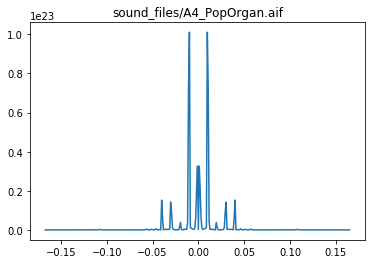

Max freq on x-axis: 0.0107421875
Max freq in Hz: 473.73046875
Note is: A#4


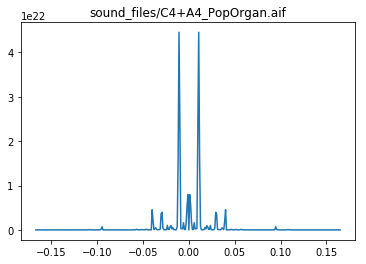

Max freq on x-axis: -0.01171875
Max freq in Hz: 516.796875
Note is: C5


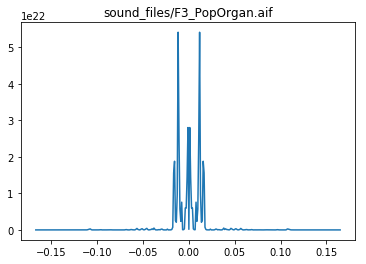

Max freq on x-axis: -0.015625
Max freq in Hz: 689.0625
Note is: F5


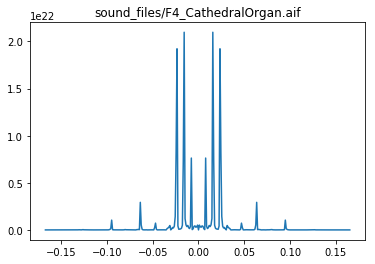

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pyaudio
from math import log2
import aifc

def get_spectrum(data): # get frequency spectrum
    fft_data = np.abs(np.fft.fft(data))**2
    freqs = np.fft.fftfreq(data.size) #, 1.0/rate)
    return freqs, fft_data
    
def get_audio(file): # read audio file
    CHUNK = 1024
    wf = aifc.open(file, 'rb')
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(), output=True)
    data = wf.readframes(CHUNK)
    #while len(data) > 0:
    #    stream.write(data)
    #    data = wf.readframes(CHUNK)
    #stream.stop_stream()
    #stream.close()
    p.terminate()
    return wf.getframerate(), np.fromstring(data, '>i4')

def pitch_to_note(freq): # freq in [Hz] to note
    A4 = 440
    C0 = A4*pow(2, -4.75)
    name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

# Main program  
for file in glob.glob('sound_files/*Organ.aif'): #sound_files/*.aif'):
    rate, data = get_audio(file)
    freqs, fft_data = get_spectrum(data)
    freqs, fft_data = np.fft.fftshift(freqs), np.fft.fftshift(fft_data)
    low_ind = int(len(fft_data)/3)
    hi_ind = int(2*len(fft_data)/3)
    freqs, fft_data = freqs[low_ind:hi_ind], fft_data[low_ind:hi_ind]
    max_freq = np.abs(freqs[np.argmax(fft_data)] * rate) # Hz
    print("Max freq on x-axis:",freqs[np.argmax(fft_data)])
    print("Max freq in Hz:",max_freq)
    print("Note is:",pitch_to_note(max_freq))
    plt.plot(freqs,fft_data)
    #plt.xlim(-0.01,0.01)
    #Pxx, freqs, bins, im = plt.specgram(data, NFFT=2048*2, Fs=rate, noverlap=512, cmap=plt.cm.viridis)
    #plt.xlabel("Time [sec]")
    #plt.ylabel("Frequency [Hz]")
    plt.title(file)
    plt.show()